In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train, test

(        id        lat        lon     score
 0        0  56.228300  43.945535  0.080523
 1        1  56.834244  53.141543  0.104424
 2        2  45.042299  41.990170  0.067615
 3        3  59.849408  30.387762  0.088038
 4        4  59.839643  30.304308  0.099686
 ...    ...        ...        ...       ...
 3079  3079  55.674584  37.279505  0.531557
 3080  3080  55.784909  49.188791  0.101631
 3081  3081  55.118828  61.462996  0.125265
 3082  3082  55.649052  37.533877  0.322601
 3083  3083  56.317263  43.887981  0.137444
 
 [3084 rows x 4 columns],
         id        lat        lon
 0     3084  55.782276  49.148234
 1     3085  56.841500  35.853059
 2     3086  55.356780  86.156697
 3     3087  56.755087  60.703962
 4     3088  59.907438  30.250297
 ...    ...        ...        ...
 1024  4108  51.692337  39.143301
 1025  4109  56.309197  43.987060
 1026  4110  59.898712  30.484624
 1027  4111  54.991157  73.407459
 1028  4112  54.377385  48.565615
 
 [1029 rows x 3 columns])

Посмотрим на распределение признаков

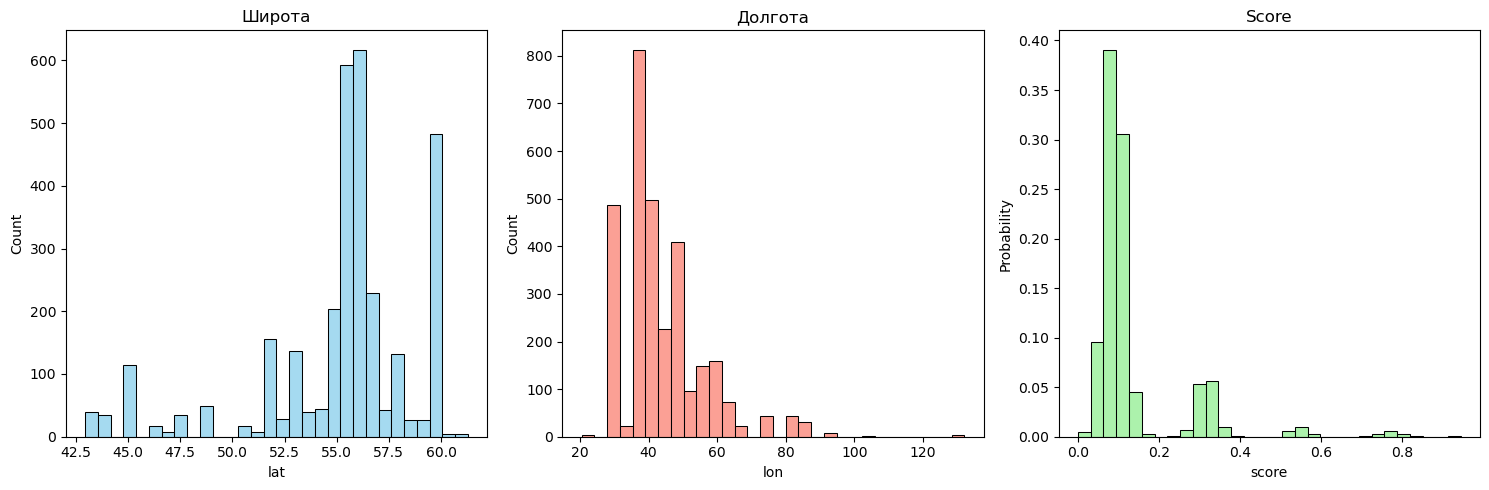

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(train['lat'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Широта')

sns.histplot(train['lon'], bins=30, ax=axes[1], color='salmon')
axes[1].set_title('Долгота')

sns.histplot(train['score'], bins=30, ax=axes[2], color='lightgreen', stat='probability')
axes[2].set_title('Score')

plt.tight_layout()
plt.show()

In [4]:
features = pd.read_csv('features.csv')
features

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
0,59.837100,30.262701,0.411159,0.360032,0.350883,0.476389,0.373542,0.399907,0.397579,0.486442,...,0.041906,0.045916,0.085368,0.093044,0.014491,0.004091,0.043260,0.045916,0.060025,0.071592
1,59.935705,30.274201,0.500628,0.458489,0.522933,0.538892,0.482807,0.497257,0.541007,0.482956,...,0.041262,0.054171,0.066940,0.057510,0.007990,0.017897,0.042617,0.054171,0.047068,0.044251
2,59.929714,30.419863,0.450037,0.413593,0.445300,0.490658,0.403224,0.448099,0.516285,0.526028,...,0.044056,0.052290,0.126482,0.116896,0.006771,0.007329,0.045406,0.052290,0.088934,0.089945
3,56.111227,40.356119,0.160964,0.146153,0.301632,0.196871,0.157927,0.130723,0.246422,0.385300,...,0.043072,0.051181,0.042962,0.030555,0.010293,0.002216,0.044425,0.051181,0.030208,0.023510
4,56.233351,43.872728,0.102522,0.073835,0.270109,0.129343,0.106780,0.082463,0.201381,0.372377,...,0.047839,0.048137,0.135698,0.163684,0.009615,0.003579,0.049185,0.048137,0.095414,0.125946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,55.491370,37.308973,0.603469,0.427283,0.616920,0.787331,0.585380,0.572505,0.414610,0.439459,...,0.040365,0.049803,0.115943,0.086169,0.003115,0.002045,0.041721,0.049803,0.081524,0.066302
3697,55.752230,52.410299,0.111785,0.105864,0.223382,0.120843,0.107082,0.094998,0.371929,0.296617,...,0.254405,0.220451,0.510766,0.568700,0.401002,0.182376,0.445025,0.417609,0.599474,0.731169
3698,59.959671,30.304035,0.439632,0.425653,0.368872,0.489872,0.389968,0.428121,0.510918,0.351653,...,0.037683,0.046643,0.048304,0.046775,0.013543,0.009374,0.039043,0.046643,0.033964,0.035991
3699,47.239728,39.761925,0.189145,0.216876,0.354758,0.177157,0.151277,0.190271,0.238387,0.298505,...,0.052133,0.047801,0.065017,0.084407,0.001219,0.004602,0.053472,0.047801,0.045716,0.064947


Проверим features на выбросы и очистим от них с помощью метода межквартильного размаха

In [5]:
cleaned_data = features.copy()

for feature in features.columns[2:]:
    Q1 = features[feature].quantile(0.25)
    Q3 = features[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cleaned_data = cleaned_data[(cleaned_data[feature] >= lower_bound) & (cleaned_data[feature] <= upper_bound)]

features = cleaned_data

Выполним нормализацию признаков

In [6]:
def standardize(column):
    return (column - column.mean()) / column.std()

In [7]:
for column in train.columns:
    if column not in ['id', 'score']:
        train[column] = standardize(train[column])
        
for column in test.columns:
    if column != 'id':
        test[column] = standardize(test[column])
        
features.apply(standardize)

,lat,lon,0,1,2,3,4,5,6,7,...,353,354,355,356,357,358,359,360,361,362
27,-1.637212,-1.366944,0.205824,0.301030,-0.139278,0.233785,0.221398,0.233751,-0.045799,-0.099156,...,0.429769,0.413146,1.435811,1.442416,1.155615,1.980557,2.360886,2.638711,2.135886,2.711236
80,0.407126,0.179973,-0.380078,0.465981,-0.841766,-0.583988,-0.939271,-0.811265,1.214775,-1.361802,...,-0.090284,0.146215,0.061999,-0.161934,-0.895555,-0.643877,-0.223980,-0.088594,-0.111434,-0.266912
84,0.402607,0.187406,0.710676,0.246049,1.050515,0.565245,0.482058,1.027041,0.804876,-0.025007,...,-0.106778,-0.205350,-0.617089,-0.692888,0.527031,0.215028,-0.233852,-0.292052,-0.594104,-0.627980
101,0.061689,2.077793,-0.423042,-1.202537,0.137753,0.148421,0.418187,-0.513963,-1.366559,0.926378,...,-0.195331,-1.701834,1.687422,1.944002,-0.382762,-0.882462,-0.286856,-1.158094,1.043852,1.165197
106,-0.882814,0.332040,1.103262,0.425610,0.238237,1.191918,0.741028,1.205407,-0.603009,0.311255,...,0.083618,0.130892,-1.775751,-1.813073,0.229280,-0.023556,-0.119889,-0.097462,-1.417634,-1.389744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,-0.332838,0.059896,-2.040338,0.065481,-3.080761,-2.993089,-2.410950,-1.996180,0.962663,-1.834387,...,-0.380053,1.196099,0.036624,-0.572525,-1.077513,1.169368,-0.397422,0.518993,-0.129470,-0.546129
3622,0.633760,-0.641503,0.165344,-0.550232,0.891420,0.643978,0.259905,0.343450,-0.546785,0.872904,...,-0.184870,0.004458,-1.343243,-1.401865,0.063863,-0.405292,-0.280595,-0.170632,-1.110225,-1.110109
3630,0.385068,0.184637,0.090671,0.076742,0.507988,0.168728,-0.219064,0.233808,0.230889,-0.369747,...,-0.253930,-0.084635,-1.642497,-1.674398,-0.432387,-0.643877,-0.321931,-0.222192,-1.322923,-1.295440
3639,0.394040,0.173711,1.148638,1.010311,-0.560334,0.526087,0.815978,1.203711,-0.472279,0.042569,...,0.279306,0.032773,0.995637,0.674549,0.460864,-0.596160,-0.002760,-0.154245,0.552158,0.301925


Соединим features с test и train, используя KD-дерево. Этот способ показал наилучший результат.

In [8]:
features_tree = KDTree(features[['lat', 'lon']])

# Поиск ближайших соседей для train и test
distances, indices = features_tree.query(train[['lat', 'lon']], k=1)
train_features = features.iloc[indices.flatten()].drop(['lat', 'lon'], axis=1).reset_index(drop=True)
train_data_with_features = pd.concat([train.reset_index(drop=True), train_features], axis=1)

distances, indices = features_tree.query(test[['lat', 'lon']], k=1)
test_features = features.iloc[indices.flatten()].drop(['lat', 'lon'], axis=1).reset_index(drop=True)
test_data_with_features = pd.concat([test.reset_index(drop=True), test_features], axis=1)

print(train_data_with_features.head())

   id       lat       lon     score         0         1         2         3  \
0   0  0.263586  0.000277  0.080523  0.199732  0.173333  0.383154  0.234153   
1   1  0.421687  0.761893  0.104424  0.199732  0.173333  0.383154  0.234153   
2   2 -2.655022 -0.161666  0.067615  0.199732  0.173333  0.383154  0.234153   
3   3  1.208392 -1.122580  0.088038  0.199732  0.173333  0.383154  0.234153   
4   4  1.205844 -1.129492  0.099686  0.199732  0.173333  0.383154  0.234153   

         4         5  ...       353       354       355       356       357  \
0  0.19819  0.166289  ...  0.038992  0.043507  0.147548  0.119016  0.006501   
1  0.19819  0.166289  ...  0.038992  0.043507  0.147548  0.119016  0.006501   
2  0.19819  0.166289  ...  0.038992  0.043507  0.147548  0.119016  0.006501   
3  0.19819  0.166289  ...  0.038992  0.043507  0.147548  0.119016  0.006501   
4  0.19819  0.166289  ...  0.038992  0.043507  0.147548  0.119016  0.006501   

        358      359       360       361       362

Отберем из всех признаков те признаки, которые несут в себе наиболее важную информацию

In [9]:
# Выберем 30 наиболее важных признаков на основе взаимной информации
selector = SelectKBest(mutual_info_regression, k=30).fit(train_data_with_features.drop(labels=["lat", "lon", "score", "id"], 
                                                                                       axis=1), train_data_with_features["score"])

train_selected = selector.transform(train_data_with_features.drop(labels=["lat", "lon", "score", "id"], axis=1))
test_selected = selector.transform(test_data_with_features.drop(labels=["lat", "lon", "id"], axis=1)) 

selected_features_indices = selector.get_support(indices=True)
selected_features_names = train_data_with_features.columns[selected_features_indices]

In [10]:
train_selected_df = pd.DataFrame(train_selected, columns=selected_features_names)
test_selected_df = pd.DataFrame(test_selected, columns=selected_features_names)

train_selected_df["id"] = train_data_with_features["id"].values
test_selected_df["id"] = test_data_with_features["id"].values
train_selected_df["lat"] = train_data_with_features["lat"].values
test_selected_df["lat"] = test_data_with_features["lat"].values
train_selected_df["lon"] = train_data_with_features["lon"].values
test_selected_df["lon"] = test_data_with_features["lon"].values
train_selected_df["score"] = train_data_with_features["score"].values

Сохраним обработанные данные для дальнейшего использования

In [11]:
train_selected_df.to_csv('train_modified.csv', index=False)
test_selected_df.to_csv('test_modified.csv', index=False)